# Run group simulation for information analysis of Kuramoto model

Import libraries

In [71]:
import infotopo_no_prints
import os
import xgi
import glob
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.animation as animation
from sklearn.utils import Bunch
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D

Define functions

In [72]:
# Normalize the first two columns individually for a given dataframe (range 0-1)
def normalize_columns(df):
    # Normalize first column (index 0)
    min_x, max_x = df.iloc[:, 0].min(), df.iloc[:, 0].max()
    df.iloc[:, 0] = (df.iloc[:, 0] - min_x) / (max_x - min_x) if max_x != min_x else 0
    
    # Normalize second column (index 1)
    min_y, max_y = df.iloc[:, 1].min(), df.iloc[:, 1].max()
    df.iloc[:, 1] = (df.iloc[:, 1] - min_y) / (max_y - min_y) if max_y != min_y else 0
    
    return df

# Optimized function to compute TSE complexity
def compute_tse_complexity(TC_dict):
    """
    Computes the TSE complexity given a dictionary of total correlations.
    
    Parameters:
        TC_dict (dict): Dictionary of total correlations where keys are tuples (subsets).
        
    Returns:
        float: The TSE complexity.
    """
    N = max(len(subset) for subset in TC_dict)  # Maximum subset size
    TSE = 0
    for gamma in range(1, N):
        TC_full = (gamma / N) * TC_dict[tuple(range(1, N + 1))]
        E_TC_gamma = np.mean([TC_dict[subset] for subset in TC_dict if len(subset) == gamma])
        TSE += TC_full - E_TC_gamma
    return TSE

# Convert pandas dataframe to bunch object
def dataframe_to_bunch(dataframe, target=None, feature_names=None, target_names=None, descr="Custom dataset"):
    if feature_names is None:
        feature_names = dataframe.columns.tolist()
    
    return Bunch(
        data=dataframe.to_numpy(),
        target=target if target is not None else np.zeros(dataframe.shape[0]),
        feature_names=feature_names,
        target_names=target_names if target_names is not None else ["target"],
        DESCR=descr
    )

# Obtain topological information metrics using infotopo
def obtain_infotopo_metrics(dataset, dimension_max=0, dimension_tot=0):

    if dimension_max == 0:
        dimension_max = 3 #dataset.shape[1]
    if dimension_tot == 0:
        dimension_tot = 9 #dataset.shape[1]
    
    sample_size = dataset.shape[0]
    nb_of_values = 16
    forward_computation_mode = True
    work_on_transpose = False
    supervised_mode = False
    sampling_mode = 1
    deformed_probability_mode = False

    information_topo = infotopo_no_prints.infotopo(dimension_max = dimension_max,
                                dimension_tot = dimension_tot,
                                sample_size = sample_size,
                                work_on_transpose = work_on_transpose,
                                nb_of_values = nb_of_values,
                                sampling_mode = sampling_mode,
                                deformed_probability_mode = deformed_probability_mode,
                                supervised_mode = supervised_mode,
                                forward_computation_mode = forward_computation_mode)
    
    Nentropie = information_topo.simplicial_entropies_decomposition(dataset)
    Ninfomut = information_topo.simplicial_infomut_decomposition(Nentropie)
    Nfree_energy = information_topo.total_correlation_simplicial_lanscape(Nentropie)
    
    return  Nentropie, Ninfomut, Nfree_energy

# Function to compute metrics for a time window sliding over a given timeseries
def interactions_values_relative(df_input, window_size=0, window_step=0, dimension_max=0, dimension_tot=0):
    # Initialize an empty DataFrame
    columns = ['R_sum', 'S_sum', 'TSE_value', 'R_std', 'S_std', 'TC_lists']
    df_output = pd.DataFrame(columns=columns)

    # Set initial window conditions
    if window_size == 0:
        window_size = len(df_input)-1
    if window_step == 0:
        window_step = 1
    window_start = 0
    window_end = window_start + window_size

    while window_end < len(df_input):
        bunch_data = dataframe_to_bunch(df_input.iloc[window_start:window_end])
        Nentropie, Ninfomut, Nfree_energy = obtain_infotopo_metrics(bunch_data.data, dimension_max, dimension_tot)

        S_values = [(TC - MI) / 2 for TC, MI in zip(Nfree_energy.values(), Ninfomut.values())]
        R_values = [(TC + MI) / 2 for TC, MI in zip(Nfree_energy.values(), Ninfomut.values())]
        S_std = np.std(S_values, ddof=1)
        R_std = np.std(R_values, ddof=1)
        S_sum = sum(S_values)
        R_sum = sum(R_values)
        TSE_value = compute_tse_complexity(Nfree_energy)

        # Add the new values to the dataframe
        new_row = pd.DataFrame({'R_sum': [R_sum], 'S_sum': [S_sum], 'TSE_value': [TSE_value], 'R_std': [R_std], 'S_std':[S_std], 'TC_lists':[Ninfomut]})
        df_output = pd.concat([df_output, new_row], ignore_index=True)
        
        window_start += window_step
        window_end += window_step

    # Normalize all the values so that the S and R values are all positive and the maximum R and S are 1 and minimum 0.
    min_R = df_output.iloc[:, 0].min()
    df_output.iloc[:, 0] += abs(min_R)

    df_output['S_sum'] = (df_output['S_sum'] - df_output['S_sum'].min()) / (df_output['S_sum'].max() - df_output['S_sum'].min())
    df_output['R_sum'] = (df_output['R_sum'] - df_output['R_sum'].min()) / (df_output['R_sum'].max() - df_output['R_sum'].min())

    return df_output

# Kuramoto model differential equation
def kuramoto(t, theta, omega, K2, N):
    dtheta = np.zeros(N)
    for i in range(N):
        interaction = np.sum(np.sin(theta - theta[i]))
        dtheta[i] = omega[i] + K2 * interaction
    return dtheta

# Simulate the Kuramoto model and save frequency time series
def simulate_kuramoto(N, K2, T=20, dt=0.01):
    # Initialize random natural frequencies and initial phases
    omega = np.random.normal(loc=0, scale=1, size=N)
    initial_phases = np.random.uniform(0, 2 * np.pi, N)
    
    # Time vector
    t_eval = np.arange(0, T, dt)
    
    # Solve the system
    sol = solve_ivp(kuramoto, [0, T], initial_phases, args=(omega, K2, N), t_eval=t_eval, method='RK45')
    
    # Compute instantaneous frequencies (time derivative of phases)
    frequencies = np.gradient(sol.y, sol.t, axis=1)

    # Convert to right data format
    frequencies_df = pd.DataFrame(frequencies).transpose()
    
    return frequencies_df

# Simulate Kuramoto model for high order interactions with XGI
def simulate_kuramoto_xgi(H, K2, K3, T=20, dt=0.01):
    timesteps=int(T/dt)
    H_int = xgi.convert_labels_to_integers(H, "label")
    links = H_int.edges.filterby("size", 2).members()
    triangles = H_int.edges.filterby("size", 3).members()
    n = H_int.num_nodes

    theta_time = np.zeros((timesteps, n))
    times = np.arange(timesteps) * dt

    omega = np.random.normal(0, 1, n)
    theta = np.random.random(n) * 2 * np.pi

    for t in range(timesteps):
        theta_time[t] = theta
        r1 = np.zeros(n, dtype=complex)
        r2 = np.zeros(n, dtype=complex)

        for i, j in links:
            r1[i] += np.exp(1j * theta[j])
            r1[j] += np.exp(1j * theta[i])

        for i, j, k in triangles:
            r2[i] += np.exp(2j * theta[j] - 1j * theta[k]) + np.exp(2j * theta[k] - 1j * theta[j])
            r2[j] += np.exp(2j * theta[i] - 1j * theta[k]) + np.exp(2j * theta[k] - 1j * theta[i])
            r2[k] += np.exp(2j * theta[i] - 1j * theta[j]) + np.exp(2j * theta[j] - 1j * theta[i])

        d_theta = omega + K2 * np.multiply(r1, np.exp(-1j * theta)).imag + K3 * np.multiply(r2, np.exp(-1j * theta)).imag
        theta_new = theta + d_theta * dt
        theta = theta_new

    frequencies_df = pd.DataFrame(theta_time, index=times)

    return frequencies_df

# Normalize a given list between 0-1
def normalize_list(values):
    min_val = min(values)
    max_val = max(values)
    return [(val - min_val) / (max_val - min_val) if max_val != min_val else 0 for val in values]

In [75]:
def simulate_kuramoto_xgi(H, K2, K3, T=20, dt=0.01):
    timesteps = int(T / dt)
    H_int = xgi.convert_labels_to_integers(H, "label")
    
    links = H_int.edges.filterby("size", 2).members()
    triangles = H_int.edges.filterby("size", 3).members()
    n = H_int.num_nodes

    theta_time = np.zeros((timesteps, n))
    times = np.arange(timesteps) * dt

    omega = np.random.normal(0, 1, n)
    theta = np.random.random(n) * 2 * np.pi

    # Create adjacency structures
    A2 = np.zeros((n, n))
    for i, j in links:
        A2[i, j] = 1
        A2[j, i] = 1

    A3 = np.zeros((n, n, n))
    for i, j, k in triangles:
        A3[i, j, k] = 1
        A3[i, k, j] = 1
        A3[j, i, k] = 1
        A3[j, k, i] = 1
        A3[k, i, j] = 1
        A3[k, j, i] = 1

    for t in range(timesteps):
        theta_time[t] = theta
        d_theta = np.zeros(n)

        for i in range(n):
            # Pairwise interaction
            for j in range(n):
                if A2[i, j]:
                    d_theta[i] += K2 * np.sin(theta[j] - theta[i])

            # Triadic interaction
            for j in range(n):
                for k in range(n):
                    if A3[i, j, k]:
                        d_theta[i] += K3 * np.sin(theta[j] + theta[k] - 2 * theta[i])

        theta = theta + (omega + d_theta) * dt

    frequencies_df = pd.DataFrame(theta_time, index=times)
    return frequencies_df

Nodes: 10
Total edges: 165
Number of pairwise edges (size 2): 45
Number of triangles (size 3): 120


(<Axes: >,
 (<matplotlib.collections.PathCollection at 0x1ee6990f1d0>,
  <matplotlib.collections.PatchCollection at 0x1ee684fa240>))

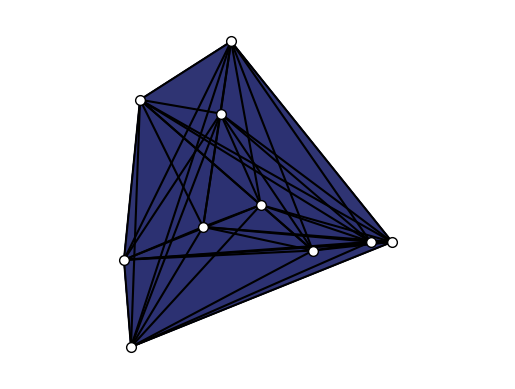

In [ ]:
# Parameters
n_nodes = 10
max_dim = 3

# Initialize empty hypergraph
H = xgi.Hypergraph()
H.add_nodes_from(range(n_nodes))

# Add all possible edges of size 2 to max_dim (inclusive)
for k in range(2, max_dim + 1):
    for edge in itertools.combinations(range(n_nodes), k):
        H.add_edge(edge)

# Count pairwise edges and triangles
pairwise_edges = len(H.edges.filterby("size", 2))
triangles = len(H.edges.filterby("size", 3))

# Print summary
print(f"Nodes: {H.num_nodes}")
print(f"Total edges: {H.num_edges}")
print(f"Number of pairwise edges (size 2): {pairwise_edges}")
print(f"Number of triangles (size 3): {triangles}")

# Optional: draw the hypergraph
xgi.draw(H, with_edge_labels=True)

In [95]:
# Parameters
model = 'XGI'
N = 10   # Number of oscillators
K = 3.0  # Coupling strength
T = 10   # Total time
dt = 0.01  # Time step
K2 = K/N # Pairwise coupling
K3 = K/N  # Triplet coupling
n_simulations = 1
max_dim = 3 # dimension max of hypergraph

# Initialize empty hypergraph
H = xgi.Hypergraph()
H.add_nodes_from(range(N))

# Add all possible edges of size 2 to max_dim (inclusive)
for k in range(2, max_dim + 1):
    for edge in itertools.combinations(range(N), k):
        H.add_edge(edge)

# Run n simulations of the same settings
if model == 'XGI':
    for n in range(n_simulations):
        # Run the simulation
        frequencies_df = simulate_kuramoto_xgi(H, K2, K3, T, dt)
        # frequencies_df = simulate_kuramoto(N, K2, T, dt)

        # Obtain information metrics
        window_size = 500
        window_step = 10
        dimension_max = 8
        dimension_tot = 8

        df_oscillators = interactions_values_relative(frequencies_df, window_size, window_step, dimension_max, dimension_tot)

        # Save to CSV
        file_path = f"Data\\Kuramoto_group_simulation\\XGI\\df_oscillators_N{N}_Kp{K2}_Kt{K3}_T{T}_dt{dt}_run{n}.csv"
        df_oscillators.to_csv(file_path, index=False)

if model == 'OG':
    for n in range(n_simulations):
        # Run the simulation
        frequencies_df = simulate_kuramoto(N, K2, T, dt)

        # Obtain information metrics
        window_size = 1000
        window_step = 10
        dimension_max = 8
        dimension_tot = 8

        df_oscillators = interactions_values_relative(frequencies_df, window_size, window_step, dimension_max, dimension_tot)

        # Save to CSV
        file_path = f"Data\\Kuramoto_group_simulation\\OG\\df_oscillators_N{N}_Kp{K2}_Kt{K3}_T{T}_dt{dt}_run{n}.csv"
        df_oscillators.to_csv(file_path, index=False)

C:\Users\cyril\AppData\Local\Temp\ipykernel_388052\3129927444.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Run simulations

In [39]:
# Choose model
model = 'XGI' # or 'OG'

# Parameters
N = 8   # Number of oscillators
K = 3.0  # Coupling strength
T = 20   # Total time
dt = 0.01  # Time step
K2 = K/N # Pairwise coupling
K3 = 0  # Triplet coupling
n_simulations = 1

# Construct an all-to-all pairwise hypergraph (equivalent to a complete graph)
H = xgi.Hypergraph()
H.add_nodes_from(range(N))  # Add nodes
for i in range(N):
    for j in range(i + 1, N):
        H.add_edge([i, j])  # Add all possible pairwise links

# Run n simulations of the same settings
if model == 'XGI':
    for n in range(n_simulations):
        # Run the simulation
        frequencies_df = simulate_kuramoto_xgi(H, K2, K3, T, dt)
        # frequencies_df = simulate_kuramoto(N, K2, T, dt)

        # Obtain information metrics
        window_size = 1000
        window_step = 10
        dimension_max = 8
        dimension_tot = 8

        df_oscillators = interactions_values_relative(frequencies_df, window_size, window_step, dimension_max, dimension_tot)

        # Save to CSV
        file_path = f"Data\\Kuramoto_group_simulation\\XGI\\df_oscillators_N{N}_Kp{K2}_Kt{K3}_T{T}_dt{dt}_run{n}.csv"
        df_oscillators.to_csv(file_path, index=False)

if model == 'OG':
    for n in range(n_simulations):
        # Run the simulation
        frequencies_df = simulate_kuramoto(N, K2, T, dt)

        # Obtain information metrics
        window_size = 1000
        window_step = 10
        dimension_max = 8
        dimension_tot = 8

        df_oscillators = interactions_values_relative(frequencies_df, window_size, window_step, dimension_max, dimension_tot)

        # Save to CSV
        file_path = f"Data\\Kuramoto_group_simulation\\OG\\df_oscillators_N{N}_Kp{K2}_Kt{K3}_T{T}_dt{dt}_run{n}.csv"
        df_oscillators.to_csv(file_path, index=False)

C:\Users\cyril\AppData\Local\Temp\ipykernel_388052\3129927444.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_output = pd.concat([df_output, new_row], ignore_index=True)


Load desired dataset

In [96]:
# Save to CSV
file_path = f"Data\\Kuramoto_group_simulation\\XGI\\df_oscillators_N{N}_Kp{K2}_Kt{K3}_T{T}_dt{dt}_run0.csv"
# file_path = f'Data\Kuramoto_group_simulation\OG\df_oscillators_N8_Kp3.0_Kt0_T200_dt0.1.csv'
df_oscillators = pd.read_csv(file_path)

In [97]:
data = df_oscillators["TC_lists"][0]
data = ast.literal_eval(data)

# Count occurrences of each key length
length_counts = {}

for key in data.keys():
    length = len(key)  # Get length of the tuple (key)
    length_counts[length] = length_counts.get(length, 0) + 1

# Initialize variables
cumulative_sum = 0
orders_list = []

# Iterate through dictionary values and compute cumulative sums
for value in length_counts.values():
    cumulative_sum += value  # Add current value to the cumulative sum
    orders_list.append(cumulative_sum)  # Store the cumulative sum

# Convert keys to strings and store in a list
keys_list = [str(key) for key in length_counts.keys()]

Visualize results

C:\Users\cyril\AppData\Local\Temp\ipykernel_388052\3337175853.py:73: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


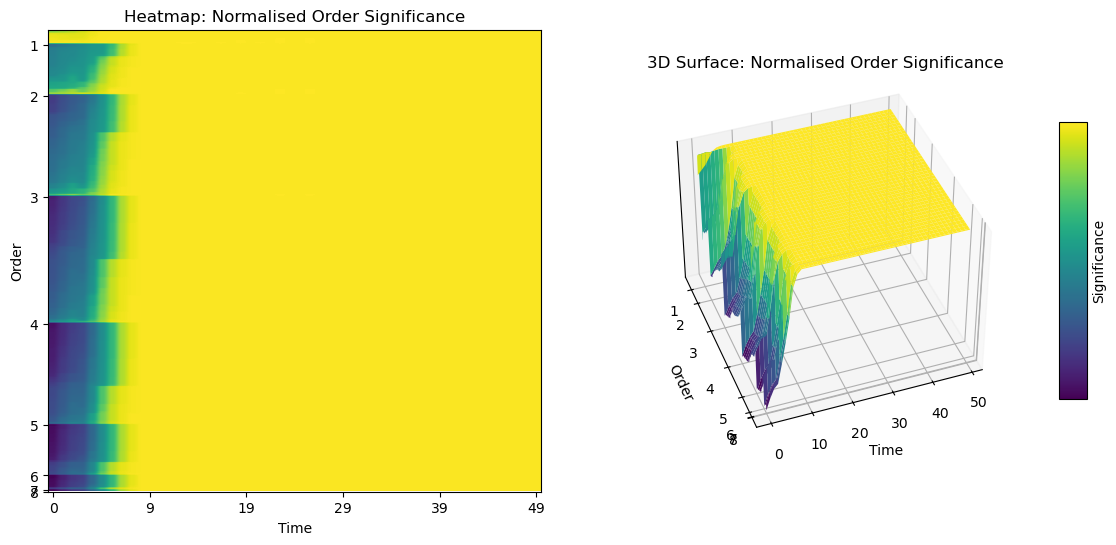

In [98]:
# Define data directly as a list of lists
data = []

for TC_dictionary in df_oscillators['TC_lists']:
    TC_dictionary = ast.literal_eval(TC_dictionary)
    sorted_dict = dict(sorted(TC_dictionary.items(), key=lambda item: (len(item[0]), item[1])))
    data.append(list(sorted_dict.values()))

# Convert to NumPy array
data = np.array(data)

# Keep only the first part
data = data[:]

# Define time and order indices
x = np.arange(data.shape[0])  # Time steps
y = np.arange(data.shape[1])  # Order indices
X, Y = np.meshgrid(x, y, indexing="xy")  # Corrected meshgrid orientation
Z = data.T  # Transpose to align with heatmap orientation

# Create figure with two subplots (side-by-side)
fig = plt.figure(figsize=(14, 6))

### First Plot (Heatmap) ###
ax1 = fig.add_subplot(1, 2, 1)  # First subplot

cax = ax1.imshow(data.T, aspect='auto', cmap='viridis', origin='lower')

# Remove colorbar for first plot
# cbar1 = fig.colorbar(cax, ax=ax1, label="Significance")  # <- This line is removed

# Set x-axis (time)
ax1.set_xlabel("Time")
ax1.set_xticks(np.linspace(0, data.shape[0] - 1, 6))
ax1.set_xticklabels(np.linspace(0, data.shape[0] - 1, 6, dtype=int))

# Set y-axis (order)
ax1.set_ylabel("Order")
ax1.set_yticks(orders_list)
ax1.set_yticklabels(keys_list)
ax1.set_title("Heatmap: Normalised Order Significance")

ax1.invert_yaxis()  # Invert y-axis direction

### Second Plot (3D Surface) ###
ax2 = fig.add_subplot(1, 2, 2, projection='3d')  # Second subplot

# Set the view angle
ax2.view_init(elev=40, azim=-110)

# Create surface plot
surf = ax2.plot_surface(X, Y, Z, cmap='viridis')

# Add colorbar only to the second plot
cbar2 = fig.colorbar(surf, ax=ax2, shrink=0.6, aspect=10, pad=0.1, label="Significance")

# Remove numbers from the colorbar
cbar2.set_ticks([])  # This removes the tick marks
cbar2.ax.set_yticklabels([])  # This removes the tick labels

# Set y-axis ticks and labels
ax2.set_yticks(orders_list)
ax2.set_yticklabels(keys_list)
ax2.invert_yaxis()  # **Ensure y-axis matches heatmap**

# Labels
ax2.set_xlabel("Time")
ax2.set_ylabel("Order")
ax2.set_zticks([])  # Remove z-axis ticks
ax2.set_title("3D Surface: Normalised Order Significance")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


C:\Users\cyril\AppData\Local\Temp\ipykernel_2796\2660296235.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


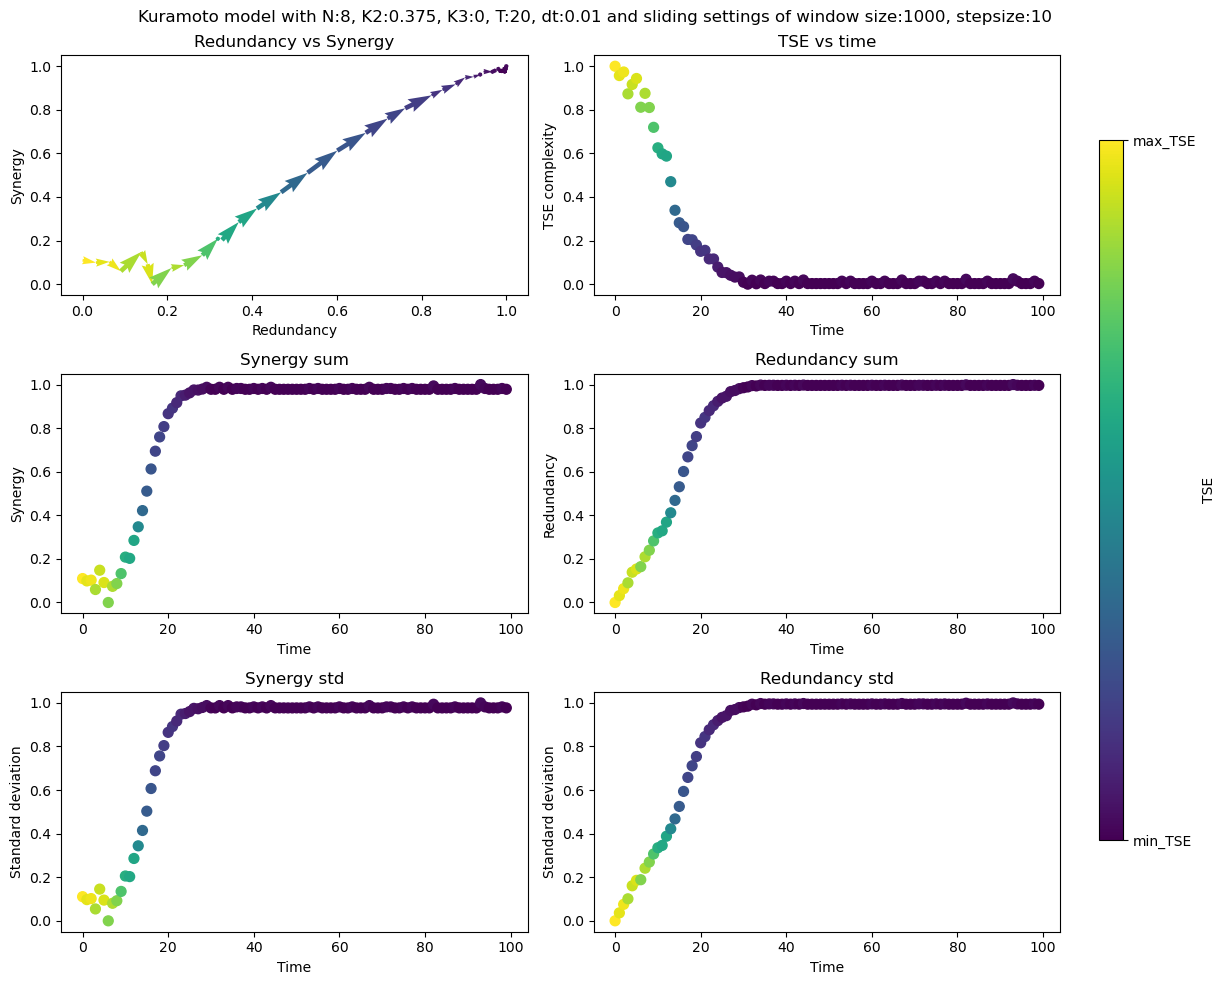

In [90]:
# Create a 2x2 figure for subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

# Extract data
df = df_oscillators
x1, y1, c1 = df['S_std'], df.index, df['TSE_value']
x2, y2, c2 = df['R_std'], df.index, df['TSE_value']
x3, y3, c3 = df['R_sum'], df['S_sum'], df['TSE_value']
x4, y4, c4 = df['S_sum'], df.index, df['TSE_value']
x5, y5, c5 = df['R_sum'], df.index, df['TSE_value']

# Compute arrow directions (differences between consecutive points)
dx3, dy3 = np.diff(x3), np.diff(y3)

# Normalize colors based on TSE_value
norm = mcolors.Normalize(vmin=df['TSE_value'].min(), vmax=df['TSE_value'].max())
cmap = plt.cm.viridis

# First subplot (Redundancy vs Synergy path)
ax1 = axes[0, 0]
q3 = ax1.quiver(x3[:-1], normalize_list(y3[:-1]), dx3, dy3, c3[:-1], cmap=cmap, norm=norm, angles='xy', scale_units='xy', scale=1, width=0.01, alpha=1)
ax1.set_xlabel('Redundancy')
ax1.set_ylabel('Synergy')
ax1.set_title('Redundancy vs Synergy')

# Second subplot (TSE vs time)
ax2 = axes[0, 1]
ax2.scatter(df.index, normalize_list(c3), c=c3, cmap=cmap, norm=norm, s=50)
ax2.set_xlabel('Time')
ax2.set_ylabel('TSE complexity')
ax2.set_title('TSE vs time')

# Third subplot (Synergy std vs time)
ax3 = axes[1, 0]
ax3.scatter(y4, normalize_list(x4), c=c4, cmap=cmap, norm=norm, s=50)
ax3.set_xlabel('Time')
ax3.set_ylabel('Synergy')
ax3.set_title('Synergy sum')

# Fourth subplot (Redundancy std vs time)
ax4 = axes[1, 1]
ax4.scatter(y5, normalize_list(x5), c=c5, cmap=cmap, norm=norm, s=50)
ax4.set_xlabel('Time')
ax4.set_ylabel('Redundancy')
ax4.set_title('Redundancy sum')

# Third subplot (Synergy std vs time)
ax3 = axes[2, 0]
ax3.scatter(y1, normalize_list(x1), c=c1, cmap=cmap, norm=norm, s=50)
ax3.set_xlabel('Time')
ax3.set_ylabel('Standard deviation')
ax3.set_title('Synergy std')

# Fourth subplot (Redundancy std vs time)
ax4 = axes[2, 1]
ax4.scatter(y2, normalize_list(x2), c=c2, cmap=cmap, norm=norm, s=50)
ax4.set_xlabel('Time')
ax4.set_ylabel('Standard deviation')
ax4.set_title('Redundancy std')

# Add a single colorbar for all subplots, placed beside the right column
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar.set_label('TSE')

# Modify the colorbar labels to 'min_TSE' and 'max_TSE'
min_TSE = c3.min()
max_TSE = c3.max()
cbar.set_ticks([min_TSE, max_TSE])
cbar.set_ticklabels(['min_TSE', 'max_TSE'])

# Adjust layout to avoid overlap
plt.suptitle(f'Kuramoto model with N:{N}, K2:{K2}, K3:{K3}, T:{T}, dt:{dt} and sliding settings of window size:{window_size}, stepsize:{window_step}')
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()